In [185]:
import datetime as dt

import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

import pandas as pd
import matplotlib.pyplot as pl

In [186]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/datasets/s-and-p-500/main/data/data.csv",
    parse_dates=['Date']
).set_index('Date').sort_index()
data = data.loc[data.index >= dt.datetime(1920, 1, 1)]

In [187]:
data['time_days'] = (data.index - min(data.index)).days


def exponential_function(x, a, b, c):
    return a * np.exp(b * x) + c


p0 = [data['Real Price'].iloc[0], 0.0001, 0]
popt_exp, pcov_exp = curve_fit(
    exponential_function,
    data['time_days'].values,
    data['Real Price'].values,
    p0=p0,
    maxfev=10000
)

data['Exponential Fit'] = exponential_function(data['time_days'], *popt_exp)
data['Deviation'] = (data['Real Price'] - data['Exponential Fit']) / \
                    data['Exponential Fit']

DatetimeIndex(['1950-01-01', '1950-01-01', '1950-02-01', '1950-03-01',
               '1950-04-01', '1950-05-01', '1950-06-01', '1950-07-01',
               '1950-08-01', '1950-09-01',
               ...
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01'],
              dtype='datetime64[ns]', name='Date', length=885, freq=None)

In [188]:
class MonteCarloModel:
    def __init__(self, _data: pd.DataFrame):
        self._data = _data
        self._date_start = min(self._data.index)

        self._exp_fit_params: tuple[float]
        self._fit_exponential()

        self._triple_gauss_params: tuple[float]

    @staticmethod
    def _exponential_function(x, a, b, c):
        return a * np.exp(b * x) + c

    def _fit_exponential(self):
        p0 = [self._data['Real Price'].iloc[0], 0.0001, 0]
        self._exp_fit_params, _ = curve_fit(
            exponential_function,
            data['time_days'].values,
            data['Real Price'].values,
            p0=p0,
            maxfev=10000
        )

    def get_exponential_fit(self, dates: pd.DatetimeIndex) -> pd.Series:
        return self._exponential_function(
            (dates - self._date_start).days,
            *self._exp_fit_params,
        )

    @staticmethod
    def _triple_gaussian_function(x, a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3,
                                  sigma3):
        return (a1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (
                sigma1 * np.sqrt(2 * np.pi)) +
                a2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (
                        sigma2 * np.sqrt(2 * np.pi)) +
                a3 * np.exp(-0.5 * ((x - mu3) / sigma3) ** 2) / (
                        sigma3 * np.sqrt(2 * np.pi)))

In [ ]:
MonteCarloModel(data)

In [189]:
data['time_days'] = (data.index - min(data.index)).days


def exponential_function(x, a, b, c):
    return a * np.exp(b * x) + c


p0 = [data['Real Price'].iloc[0], 0.0001, 0]
popt_exp, pcov_exp = curve_fit(
    exponential_function,
    data['time_days'].values,
    data['Real Price'].values,
    p0=p0,
    maxfev=10000
)

data['Exponential Fit'] = exponential_function(data['time_days'], *popt_exp)
data['Deviation'] = (data['Real Price'] - data['Exponential Fit']) / \
                    data['Exponential Fit']

/tmp/ipykernel_7922/2997357502.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


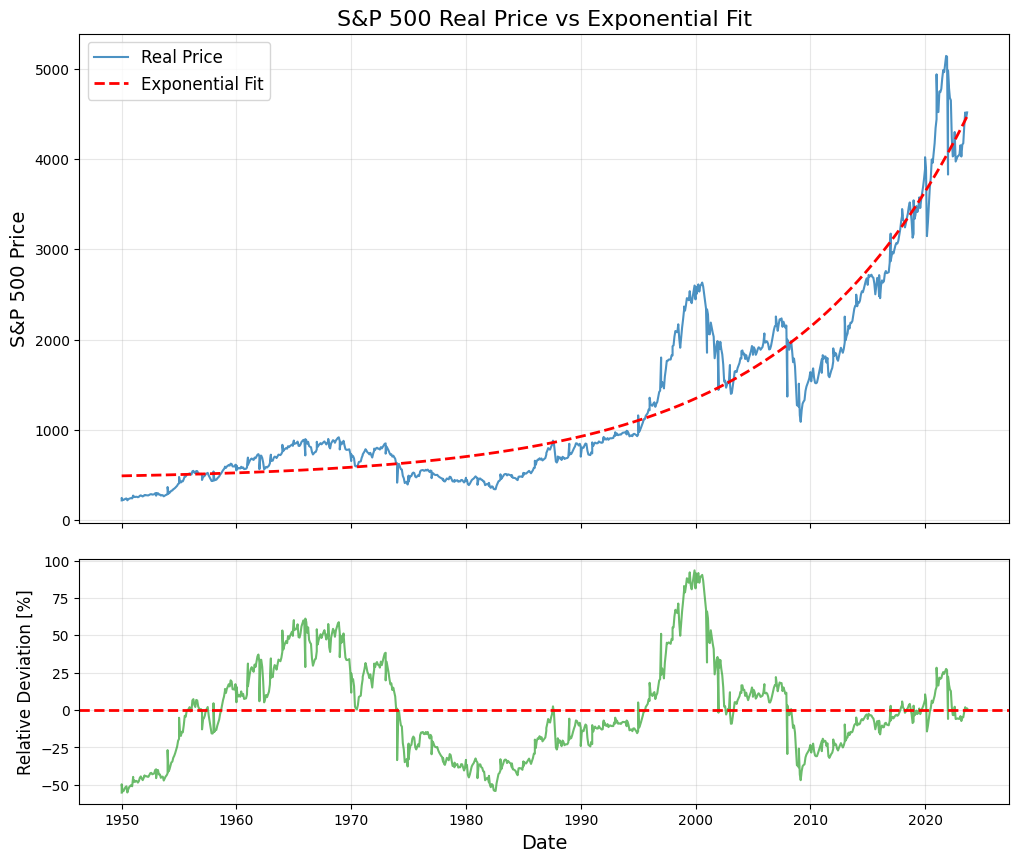

In [190]:
# Fit triple Gaussian distribution
def triple_gaussian_function(x, a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3,
                             sigma3):
    return (a1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (
            sigma1 * np.sqrt(2 * np.pi)) +
            a2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (
                    sigma2 * np.sqrt(2 * np.pi)) +
            a3 * np.exp(-0.5 * ((x - mu3) / sigma3) ** 2) / (
                    sigma3 * np.sqrt(2 * np.pi)))


# Initial guess for triple Gaussian parameters
p0_triple = [0.33, data['Brownian Motion'].mean(), data['Brownian Motion'].std(),
             0.33, data['Brownian Motion'].mean() - data['Brownian Motion'].std(),
             data['Brownian Motion'].std() * 0.5,
             0.34, data['Brownian Motion'].mean() + data['Brownian Motion'].std(),
             data['Brownian Motion'].std() * 1.5]


popt_triple, pcov_triple = curve_fit(
    triple_gaussian_function,
    bin_centers,
    hist_counts,
    p0=p0_triple
)
a1_t, mu1_t, sigma1_t, a2_t, mu2_t, sigma2_t, a3_t, mu3_t, sigma3_t = popt_triple

In [191]:
pl.figure(figsize=(12, 8))
pl.hist(data['Brownian Motion'], bins=100, alpha=0.7, density=True, label='Data')

x_fit = np.linspace(data['Brownian Motion'].min(), data['Brownian Motion'].max(), 1000)

pl.plot(x_fit, triple_gaussian_function(x_fit, *popt_triple), 'r-', linewidth=2,
        label=f'Triple Gaussian fit')
pl.plot(x_fit, a1_t * stats.norm.pdf(x_fit, mu1_t, sigma1_t), 'g--',
        linewidth=1,
        label=f'Component 1 (μ={mu1_t:.4f}, σ={sigma1_t:.4f})')
pl.plot(x_fit, a2_t * stats.norm.pdf(x_fit, mu2_t, sigma2_t), 'b--',
        linewidth=1,
        label=f'Component 2 (μ={mu2_t:.4f}, σ={sigma2_t:.4f})')
pl.plot(x_fit, a3_t * stats.norm.pdf(x_fit, mu3_t, sigma3_t), 'm--',
        linewidth=1,
        label=f'Component 3 (μ={mu3_t:.4f}, σ={sigma3_t:.4f})')

pl.grid(True)
pl.legend(fontsize=14)
pl.xlabel('Monthly difference [%]', fontsize=14)
pl.title('Triple Gaussian fit to Brownian motion', fontsize=18)
pl.show()

In [192]:
class MonteCarloSamples:
    def __init__(self, a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3, sigma3):
        self._a1 = a1
        self._mu1 = mu1
        self._sigma1 = sigma1

        self._a2 = a2
        self._mu2 = mu2
        self._sigma2 = sigma2

        self._a3 = a3
        self._mu3 = mu3
        self._sigma3 = sigma3

        self._samples: np.ndarray = None
        self._sample_weights: np.ndarray = None

    def draw(self, n_samples: int) -> np.ndarray:
        total_weight = self._a1 + self._a2 + self._a3
        prob_component1 = self._a1 / total_weight
        prob_component2 = self._a2 / total_weight

        component_choice = np.random.random(n_samples)

        return np.where(
            component_choice < prob_component1,
            np.random.normal(mu1_t, sigma1_t, n_samples),
            np.where(
                component_choice < prob_component1 + prob_component2,
                np.random.normal(mu2_t, sigma2_t, n_samples),
                np.random.normal(mu3_t, sigma3_t, n_samples)
            )
        )

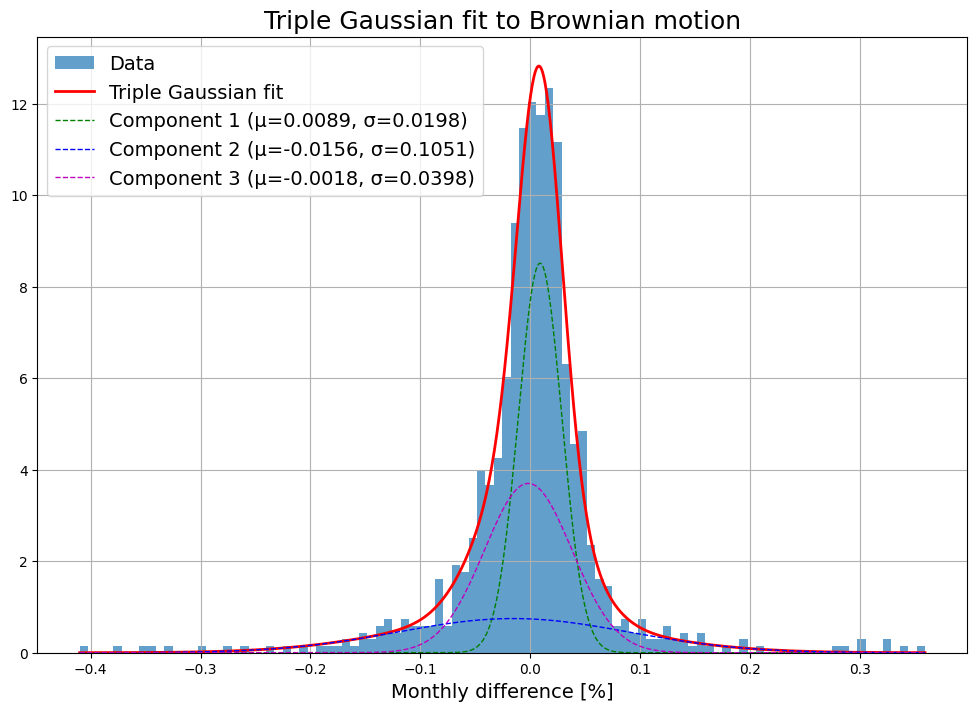

In [193]:
monte_carlo_samples = MonteCarloSamples(a1_t, mu1_t, sigma1_t, a2_t, mu2_t,
                                        sigma2_t, a3_t, mu3_t, sigma3_t)

In [194]:
mc_brownian = []
for _ in range(len(data)):
    mc_brownian.append(monte_carlo_samples.draw(100))

In [195]:
mc_brownian = np.vstack(mc_brownian)

TypeError: MonteCarloModel.__init__() takes 2 positional arguments but 10 were given

In [196]:
pl.figure(figsize=(12, 8))
for i in range(50):
    pl.plot(
        (data['Deviation'].iloc[0] + np.cumsum(mc_brownian[:, i])) * data['Exponential Fit'] + data['Exponential Fit'],
        color='grey',
        alpha=0.1
    )
pl.grid(True)
pl.show()